# DataFrame Generation and Analysis for Comparison

In [1]:
from TCSPC import *

In [2]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])

### Update on Phasor.generate_df() 11/03/2024

OptimizeResult from `scipy.optimize.root()` is used to generate df\
It includes success, nfev, and parameter results \
Access the `df` using `EGFP.df`\
Background is removed in EGFP.phasor_data

In [3]:
def repeat_sim_n(sim,n_photon_arr = np.logspace(4,9,20).astype(int),n_repeat = 100):
    '''Store results of simulations for Simulation object sim 
    of n_photon in n_photon_arr (default  np.logspace(6,10,100).astype(int))
    Input:
    sim            Simulation Object
    n_photon_arr   Number of photons (collected in total) array
    n_repeat       Number of repeats in simulation
    '''
    sim.y_list = np.zeros((len(n_photon_arr),n_repeat,380)) #array to store 100 simulations of time domain data for each n_photon
    sim.y_bg_list= np.zeros((len(n_photon_arr),n_repeat,380))
    sim.phasor_list = np.zeros((len(n_photon_arr),n_repeat,380),dtype = complex) #array to store phasors from simulations of different n_photon
    sim.phasor_bg_list = np.zeros((len(n_photon_arr),n_repeat,380),dtype = complex) #with background
    for i in range(len(n_photon_arr)):
        sim.n_photon = n_photon_arr[i] #set n_photon
        sim.repeat_sim(n_repeat) #generate 100 simulations
        sim.y_list[i] = sim.sim_data- sim.run_time*sim.bg/sim.n_bins#store 100 decays, no bg
        sim.y_bg_list[i] = sim.sim_data  #store 100 decays, with bg
        sim.phasor_list[i] = sim.phasor_data #store 100 phasors, no bg
        w,sim.phasor_bg_list[i] = sim.phasor_fft(sim.sim_data) #phasor with backhround

In [4]:
repeat_sim_n(EGFP) #access the data from EGFP.y_list, EGFP.y_bg_list, EGFP.phasor_list and EGFP.phasor_bg_list

In [5]:
#np.save('df/EGFP_data',[EGFP.y_list,EGFP.y_bg_list,EGFP.phasor_list,EGFP.phasor_bg_list])
EGFP.y_list,EGFP.y_bg_list,EGFP.phasor_list,EGFP.phasor_bg_list = np.load('df/EGFP_data.npy')
EGFP.y_list=EGFP.y_list.astype(int)
EGFP.y_bg_list=EGFP.y_bg_list.astype(int)

C:\Users\Koukaze\AppData\Local\Temp\ipykernel_10372\2602227171.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  EGFP.y_list=EGFP.y_list.astype(int)
C:\Users\Koukaze\AppData\Local\Temp\ipykernel_10372\2602227171.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  EGFP.y_bg_list=EGFP.y_bg_list.astype(int)


In [8]:
n_photon_arr = np.logspace(4,9,20)
df_list = []   #mle
df_ls_list = [] #least squares
df_p_list = [] #phasor
N=2 #N components
for i in range(len(n_photon_arr)):
    df_bg = EGFP.val_df(N,sim_data=EGFP.y_bg_list[i])
    df_no_bg = EGFP.val_df(N,sim_data=EGFP.y_list[i],bg=False)
    df_rescale= EGFP.val_df(N,sim_data=EGFP.y_list[i],rescale = True)
    df_no_bg_rescale= EGFP.val_df(N,sim_data=EGFP.y_list[i],r=30,rescale = True,bg=False)
    df_list.append([df_bg,df_no_bg,df_rescale,df_no_bg_rescale])

for i in range(len(n_photon_arr)):
    df_bg = EGFP.val_df(N,resid_func = LS_deviance_residual,sim_data=EGFP.y_bg_list[i])
    df_no_bg = EGFP.val_df(N,resid_func = LS_deviance_residual,sim_data=EGFP.y_list[i],bg=False)
    df_rescale= EGFP.val_df(N,resid_func = LS_deviance_residual,sim_data=EGFP.y_list[i],rescale = True)
    df_no_bg_rescale= EGFP.val_df(N,resid_func = LS_deviance_residual,sim_data=EGFP.y_list[i],r=30,rescale = True,bg=False)
    df_ls_list.append([df_bg,df_no_bg,df_rescale,df_no_bg_rescale])

for i in range(len(n_photon_arr)):
    df_bg_1 = EGFP.generate_df(phasor_data = EGFP.phasor_bg_list[i],idx = None)
    df_bg_2 = EGFP.generate_df(phasor_data = EGFP.phasor_bg_list[i],idx = [0,2,4]) #use harmonics aside from first
    df_no_bg = EGFP.generate_df(phasor_data = EGFP.phasor_list[i])
    df_p_list.append([df_bg_1,df_bg_2,df_no_bg])

c:\Users\Koukaze\OneDrive\F300\☽\PHAS0052 Physics Group Project\TCSPC.py:750: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-self.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
c:\Users\Koukaze\OneDrive\F300\☽\PHAS0052 Physics Group Project\TCSPC.py:193: RuntimeWarning: invalid value encountered in divide
  phasor = (np.fft.fft(y).T/y_sum).T/np.fft.fft(ker)*np.sum(ker)


In [9]:
def n_case_df(df_list,col):
    '''Return df for cases in df_list
       Input:
       df_list  list of the structure [[df_1,df_2,...df_n_case],...,] (nested list of 20 (n_photon_arr) by n_case)
       col      col names for the cases'''
    df_list_case = []
    for df in df_list:
        n_val_df =pd.concat(df,keys = col,axis = 1) #concat dfs of n cases along axis 1
        df_list_case.append(n_val_df) #append each photon number case
    return pd.concat(df_list_case,keys = range(20)) 

In [10]:
df_no_bg_rescale= EGFP.val_df(2,resid_func = LS_deviance_residual,sim_data=EGFP.y_list[0],r=10,rescale = True,bg=False)

In [11]:
df_no_bg_rescale

,c,A1,A2,tau1,tau2,red_chi2,nfev
0,0,0.445901,0.554099,1.459946,3.278852e+00,0.776339,835
1,0,0.955602,0.044398,2.103139,3.533085e+01,0.947188,258
2,0,0.826206,0.173794,2.089047,5.004836e+00,0.852816,244
3,0,0.819272,0.180728,2.102066,4.811607e+00,0.566547,244
4,0,0.965968,0.034032,2.020664,3.869328e+11,1.190061,215
...,...,...,...,...,...,...,...
95,0,0.960290,0.039710,2.070520,3.068842e+15,0.933109,232
96,0,0.750805,0.249195,2.253711,3.753971e+00,0.675196,210
97,0,0.969000,0.031000,2.165365,5.825084e+13,1.160112,366
98,0,0.130680,0.869320,0.076421,2.730696e+00,0.674809,1027


In [12]:
EGFP.n_photon = int(1e3)
EGFP.repeat_sim(100)
EGFP.generate_df()
EGFP.df[['A1','tau1','tau2','nfev','success']]

c:\Users\Koukaze\OneDrive\F300\☽\PHAS0052 Physics Group Project\TCSPC.py:750: RuntimeWarning: overflow encountered in exp
  y  = sum([A_tau_arr[j] * np.exp(-self.t / A_tau_arr[j+n-1]) for j in range(n-1)]) #pure multiexponential
c:\Users\Koukaze\OneDrive\F300\☽\PHAS0052 Physics Group Project\TCSPC.py:193: RuntimeWarning: invalid value encountered in divide
  phasor = (np.fft.fft(y).T/y_sum).T/np.fft.fft(ker)*np.sum(ker)


,A1,tau1,tau2,nfev,success
0,0.509186,2.077108,3.359392,14,True
1,0.472964,2.619956,3.126958,13,True
2,0.538680,1.985613,3.116514,16,True
3,0.553106,1.815597,3.153086,15,True
4,0.511529,2.565142,2.719770,13,True
...,...,...,...,...,...
95,0.501014,2.846088,2.846559,44,False
96,0.528753,1.411872,3.833320,20,True
97,0.502924,2.033021,3.498348,13,True
98,0.503124,2.903339,2.904391,39,False


In [13]:
EGFP.mle_df

,index,c,A1,A2,tau1,tau2,red_chi2,nfev
0,0,0,0.445901,0.554099,1.459946,3.278852e+00,0.776339,835
1,0,0,0.955602,0.044398,2.103139,3.533085e+01,0.947188,258
2,0,0,0.826206,0.173794,2.089047,5.004836e+00,0.852816,244
3,0,0,0.819272,0.180728,2.102066,4.811607e+00,0.566547,244
4,0,0,0.965968,0.034032,2.020664,3.869328e+11,1.190061,215
...,...,...,...,...,...,...,...,...
95,0,0,0.960290,0.039710,2.070520,3.068842e+15,0.933109,232
96,0,0,0.750805,0.249195,2.253711,3.753971e+00,0.675196,210
97,0,0,0.969000,0.031000,2.165365,5.825084e+13,1.160112,366
98,0,0,0.130680,0.869320,0.076421,2.730696e+00,0.674809,1027


In [14]:
EGFP.df[EGFP.df.success ==False]

,x,success,status,method,nfev,fjac,r,qtf,fun,message,A1,tau1,tau2
7,"[0.45092200684534334, 2.7105601123990812, 2.71...",False,5,hybr,50,"[[-0.00011842967555963924, -0.7832346593140593...","[-0.00027903465355746834, 0.10331457110362018,...","[-5.904297667711812e-06, -0.003241276433790996...","[-4.440892098500626e-16, -0.003067142720745708...","The iteration is not making good progress, as ...",0.450922,2.710560,2.711778
8,"[0.48938308175540346, 2.7892794595867842, 2.78...",False,5,hybr,41,"[[-0.00021969219572071097, 0.7940225183833783,...","[-0.0002771974330070183, -0.10849727207769233,...","[1.5756482908351778e-05, 0.006604381930964535,...","[-2.220446049250313e-16, -0.006972622669551898...","The iteration is not making good progress, as ...",0.489383,2.789279,2.789616
10,"[0.40789495002480947, 2.8482769093263625, 2.83...",False,5,hybr,45,"[[0.0, 0.8009517053192329, 0.5987289584997644]...","[-0.0023909355777905054, -0.08720483721040774,...","[5.348493461952361e-05, 0.022099963827972913, ...","[1.1102230246251565e-16, -0.013243026568514726...","The iteration is not making good progress, as ...",0.407895,2.848277,2.837670
17,"[0.6044858815647393, 2.753443513243485, 2.7549...",False,5,hybr,39,"[[-2.1376775739867618e-07, 0.7870135077407504,...","[0.0029527333292153467, -0.12568368554224899, ...","[0.00011020138695071501, 0.022821905637817424,...","[-1.1102230246251565e-16, -0.01399291987223183...","The iteration is not making good progress, as ...",0.604486,2.753444,2.754970
19,"[0.2728462918085205, 2.9473661825334516, 2.942...",False,5,hybr,45,"[[-5.1497808225331454e-05, -0.8132791363999046...","[0.0010605064429360363, 0.05671041366052341, 0...","[4.241252333746226e-07, 0.0021196676550209147,...","[1.1102230246251565e-16, -0.001239983511629905...","The iteration is not making good progress, as ...",0.272846,2.947366,2.942261
23,"[0.47306809375198183, 2.8617041666723897, 2.86...",False,5,hybr,34,"[[2.611760322459527e-09, -0.8032831594230806, ...","[-0.00022971273441234235, 0.10161224497605577,...","[7.417654256462985e-07, 0.0035035576482894955,...","[3.3306690738754696e-16, -0.002086538346087962...","The iteration is not making good progress, as ...",0.473068,2.861704,2.861433
33,"[0.5207173847861747, 2.888667807514553, 2.8969...",False,5,hybr,36,"[[-3.257329922793987e-05, -0.8092901034274631,...","[-0.001757670075484172, 0.11042618731697004, 0...","[9.252444338922645e-05, 0.023422215611365302, ...","[-1.1102230246251565e-16, -0.01383386987847024...","The iteration is not making good progress, as ...",0.520717,2.888668,2.896935
34,"[0.48229487764913304, 2.7927582716850794, 2.79...",False,5,hybr,30,"[[-0.00018794814751762394, 0.7983237924178118,...","[0.00024655259446492616, -0.10674681280406689,...","[-8.465052808052691e-08, -1.8863240313508e-05,...","[4.440892098500626e-16, -1.1432373590802847e-0...","The iteration is not making good progress, as ...",0.482295,2.792758,2.792726
35,"[0.44926564409849123, 2.764756902591157, 2.762...",False,4,hybr,48,"[[-6.387739320512509e-05, -0.7905785570033173,...","[0.0005192418867848589, 0.1007254279118578, 0....","[-4.846400728088056e-06, 0.007689795698755445,...","[0.0, -0.004877474972289186, 0.006304901617182...","The iteration is not making good progress, as ...",0.449266,2.764757,2.762440
36,"[0.7099082378696473, 2.8645390518647496, 2.864...",False,5,hybr,35,"[[-0.0018361635806900221, -0.7194319996388518,...","[1.14293978361171e-05, 0.15110823335724896, 0....","[-0.000358589171106867, -0.0027235402988477165...","[1.1102230246251565e-16, -0.001633876706434334...","The iteration is not making good progress, as ...",0.709908,2.864539,2.864534


In [15]:
n_photon_arr = np.logspace(3,8,40)
df_low_list = [] #for low number of photon count
for n_photon in n_photon_arr:
    EGFP.n_photon = n_photon
    EGFP.repeat_sim(100)
    EGFP.generate_df()
    df_low_list.append(EGFP.df)
df_low = pd.concat(df_low_list,keys = range(len(n_photon_arr)))

In [16]:
df_low 

x  success  status  \
0  0   [0.6593912027175424, 2.74731524916092, 2.74749...    False       5   
   1   [0.5174459695433435, 2.564041298633804, 2.6480...     True       1   
   2   [0.5163359376053182, 1.5666114956465385, 3.689...     True       1   
   3   [0.4875336948974296, 2.6145769044468365, 2.953...     True       1   
   4   [0.49044253348625283, 2.431353325938327, 3.149...     True       1   
...                                                  ...      ...     ...   
39 95  [0.4969456594292981, 2.4321893352357704, 3.067...     True       1   
   96  [0.49692460247422643, 2.4325662299508295, 3.06...     True       1   
   97  [0.49702215073682576, 2.4303412853643143, 3.06...     True       1   
   98  [0.49718079714339936, 2.4263630044060274, 3.07...     True       1   
   99  [0.497016996290843, 2.4297623283235015, 3.0700...     True       1   

      method  nfev                                               fjac  \
0  0    hybr    49  [[-7.568213436511525e-05, -0.7830645488044441,...   
   1    hybr    20  [[-1.4284465343905595e-06, 0.7674671832923351,...   
   2    hybr    26  [[-1.2904056512219597e-07, -0.7289687990218839...   
   3    hybr    13  [[-7.428085460223106e-07, 0.7815925802874321, ...   
   4    hybr    18  [[-8.511778376574242e-08, 0.787763297084889, 0...   
...      ...   ...                                                ...   
39 95   hybr     8  [[-4.193027598143814e-07, 0.785243279157813, 0...   
   96   hybr     8  [[-4.122789114553824e-07, 0.7852442250000888, ...   
   97   hybr     7  [[-4.2057377271430033e-07, 0.7852331347192533,...   
   98   hybr     8  [[-4.2066650267438226e-07, 0.7852058666821626,...   
   99   hybr    17  [[-2.1020720830655648e-07, 0.7852194617965045,...   

                                                       r  \
0  0   [-0.0005963836443513712, 0.1488544778854481, 0...   
   1   [0.020160027410644737, -0.12242367449630512, -...   
   2   [-0.44729238033058033, 0.04426760573618253, 0....   
   3   [0.12014347015448314, -0.09884355431861107, -0...   
   4   [0.15440469760276646, -0.09496229233020852, -0...   
...                                                  ...   
39 95  [0.14255212103309156, -0.09901740386405518, -0...   
   96  [0.1425324813584348, -0.09896699434258063, -0....   
   97  [0.1425498492584954, -0.09898669569561422, -0....   
   98  [0.14254625641545193, -0.09892648692661235, -0...   
   99  [0.14262684257547376, -0.09897470240754727, -0...   

                                                     qtf  \
0  0   [-8.715826239322167e-05, 0.010348155619336965,...   
   1   [-2.246849189901169e-10, 3.7198358353118e-12, ...   
   2   [-5.022863392328084e-10, 1.339830790942369e-10...   
   3   [1.658929124443417e-10, -8.975824396321526e-12...   
   4   [8.745928558785481e-17, -6.838721066911058e-17...   
...                                                  ...   
39 95  [-2.977507334365166e-14, 5.451819480514282e-15...   
   96  [5.573734002782606e-12, -1.1776817454300648e-1...   
   97  [-6.998991057682088e-12, 5.207194510415724e-12...   
   98  [-5.569979409779226e-13, -2.5949845079531984e-...   
   99  [1.8429912435878787e-17, -1.559238327376802e-1...   

                                                     fun  \
0  0   [-1.1102230246251565e-16, -0.00636794099372417...   
   1   [1.1102230246251565e-16, 1.1102230246251565e-1...   
   2   [1.1102230246251565e-16, 0.0, 5.55111512312578...   
   3   [2.220446049250313e-16, -9.373279930002809e-12...   
   4   [1.1102230246251565e-16, 1.1102230246251565e-1...   
...                                                  ...   
39 95  [-2.220446049250313e-16, -2.6756374893466273e-...   
   96  [-3.3306690738754696e-16, 4.449662860395165e-1...   
   97  [0.0, 6.499245586155666e-13, 4.868883074493624...   
   98  [0.0, 4.440892098500626e-16, 6.106226635438361...   
   99  [0.0, 1.1102230246251565e-16, -1.1102230246251...   

                                                 message        A1      tau1  \
0  0   The

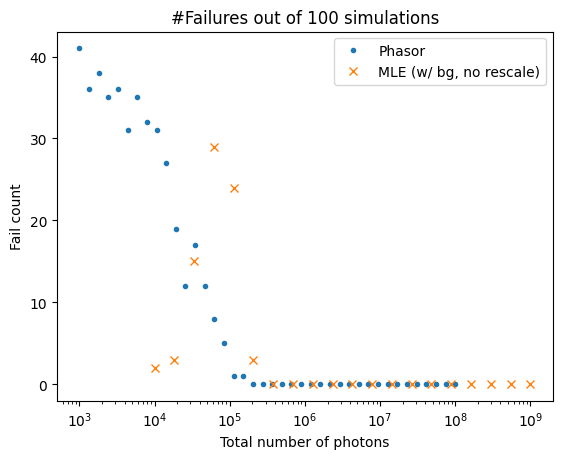

In [19]:
fail_count = np.zeros(40)
fail = df_low[df_low.success==False].groupby(level=0).size()
fail_count[:len(fail)] = fail
n_photon_arr = np.logspace(3,8,40).astype(int)
n_photon_arr2, fail_count_fit = np.loadtxt('Book3.csv',delimiter = ',',skiprows = 1,unpack = True)

plt.figure()
plt.title('#Failures out of 100 simulations')
plt.plot(n_photon_arr,fail_count,'.',label = 'Phasor')
plt.plot(n_photon_arr2,fail_count_fit,'x',label = 'MLE (w/ bg, no rescale)')
plt.xscale('log')
plt.xlabel('Total number of photons')
plt.ylabel('Fail count')
plt.legend()
plt.savefig('fig/fail_compare.pdf')


In [20]:
EGFP.n_photon = n_photon_arr[fail_count == 0][0]
EGFP.multi_exp_data()
np.max(EGFP.y2)

3847

In [21]:
n_photon_arr2[fail_count_fit==0][0]

379269.0190732254

In [22]:
n_photon_arr = np.logspace(3,8,20)
repeat_sim_n(EGFP,n_photon_arr)